## Importing packages and uploading the raw data

In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
raw_data = pd.read_csv('data/organisations.csv')

## Data processing

In [3]:
# Check for missing values in the dataframe
count_nan_in_df = raw_data.isnull().sum()
print (count_nan_in_df)

permalink               0
name                    0
homepage_url         1166
category_list         831
market                833
funding_total_usd       0
status                644
country_code            0
state_code           8415
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
dtype: int64


In [4]:
# replace the missing values with variable name + 'missing'
values = {"homepage_url": 'url_missing', "category_list": 'category_missing', "market": 'market_missing', "status": 'status_missing', 'state_code': 'state_missing'}
raw_data = raw_data.fillna(value=values)
count_nan_in_df = raw_data.isnull().sum()
print (count_nan_in_df)

permalink            0
name                 0
homepage_url         0
category_list        0
market               0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
dtype: int64


### Remove variables that are not used

In [5]:
# Permalink, name, homepage_url can be used to gather secondary data on the companies but have no predictive power by themselves
# As we do not gather secondary data, these variables are removed from the dataset
raw_data = raw_data.drop(columns=['permalink', 'name','homepage_url'])

### Converting variables to correct format and datatype

In [6]:
# Convert date-type variables to ordinal variables
raw_data['founded_at'] = pd.to_datetime(raw_data['founded_at']).apply(pd.Timestamp.toordinal)
raw_data['first_funding_at'] = pd.to_datetime(raw_data['first_funding_at']).apply(pd.Timestamp.toordinal)
raw_data['last_funding_at'] = pd.to_datetime(raw_data['last_funding_at']).apply(pd.Timestamp.toordinal)

In [7]:
# Convert numbers to integer variables
raw_data[['funding_total_usd', 'funding_rounds']] = raw_data[['funding_total_usd', 'funding_rounds']].astype('int')

In [8]:
# Splits category list by seperator | for easier comprehension, first one removes unneccesary |s
raw_data["category_list"] = raw_data["category_list"].str.slice(1,-1).str.split("|")

In [9]:
# Convert top 3 markets to dummy variables
top3markets = [' Software ',' Biotechnology ',' Mobile ']
raw_data['market'] = np.where(raw_data['market'].isin(top3markets), raw_data['market'], 'Other')
market = pd.get_dummies(raw_data['market'], drop_first=True)

# Convert status to dummy variables
status = pd.get_dummies(raw_data['status'], drop_first=True)

#Convert country_code to dummy variables USA and others
USA = ['USA']
raw_data['country_code'] = np.where(raw_data['country_code'].isin(USA), raw_data['country_code'], 'Other_countries')
country_code = pd.get_dummies(raw_data['country_code'], drop_first=True)

In [10]:
#Convert top 15 regions to dummy variables
imp_region = ['SF Bay Area', 'New York City', 'Boston', 'London', 'Los Angeles', 'Seattle', 'Washington, D.C.', 'Chicago', 'San Diego', 'Denver', 'Austin', 'Tel Aviv', 'Paris','Atlanta','Toronto']

raw_data['region'] = np.where(raw_data['region'].isin(imp_region), raw_data['region'], 'Other_regions')
region = pd.get_dummies(raw_data['region'], drop_first=True)

In [11]:
#Convert city into dummy variable 
city = pd.get_dummies(raw_data['city'], drop_first=True)

In [12]:
# drop orginal variables that were made into dummy variabeles
raw_data = raw_data.drop(columns=['market', 'status', 'country_code', 'state_code', 'region', 'city', 'category_list'])

## Create processed dataset that is ready for modelling

In [13]:
processed_data = pd.concat([raw_data, status, country_code, region, market], axis=1)

In [14]:
print(processed_data)

       funding_total_usd  funding_rounds  founded_at  first_funding_at  \
0                1750000               1      734655            734684   
1                  40000               1      734802            734724   
2                1500000               1      734228            734228   
3                  60000               2      735234            735462   
4                7000000               1      734420            735019   
...                  ...             ...         ...               ...   
28724           15419877               4      727929            733042   
28725            2686600               1      732677            734897   
28726             320000               1      734896            735316   
28727              97398               5      734636            734442   
28728           45000000               4      729755            733194   

       last_funding_at  closed  operating  status_missing  USA  Austin  ...  \
0               734684       0  

## Split data into features, labels and training, test data

In [15]:
from sklearn.model_selection import train_test_split

X = processed_data.drop(columns='funding_total_usd')
y = processed_data['funding_total_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [16]:
X_train.shape

(20110, 26)

## Modelling
In the modelling stage, the following models are tested: Linear Regression, Random Forest, Gradient Boosted Regression Tree, and
Histrogram Based Boosted Regression Tree. Each model will be tested using gridsearchcv and cross validation to find the optimal parameters and model score.

## Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

linear_regression_model = LinearRegression()

In [18]:
linear_param_grid = {'fit_intercept': [True,False],
                     'normalize': [True,False]}

linear_grid = GridSearchCV(estimator=linear_regression_model, param_grid=linear_param_grid, cv=5, n_jobs=-1)

linear_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [19]:
linear_grid.best_score_

0.08412620917151829

In [20]:
linear_model = linear_grid.best_estimator_
linear_model.score(X_test, y_test)

0.1341519690583095

In [21]:
linear_grid.best_params_

{'fit_intercept': False, 'normalize': True}

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor()

In [23]:
random_forest_param_grid = {'max_depth': [2, 5, 10],
                            'n_estimators': [50, 100, 200],
                            'min_samples_leaf': [1, 2, 3],
                            'min_samples_split': [2, 4, 6]}

random_forest_grid = GridSearchCV(estimator=random_forest_model, param_grid=random_forest_param_grid, cv=5, n_jobs=-1)

In [24]:
random_forest_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]})

In [25]:
random_forest_grid.best_score_

0.10112016143736369

In [26]:
random_forest_model = random_forest_grid.best_estimator_
random_forest_model.score(X_test, y_test)

-0.0010726134539047472

In [27]:
random_forest_grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

## Gradient Boosting Regression Tree

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

boost_model = GradientBoostingRegressor()

In [29]:
boost_param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5],
                    'max_leaf_nodes': [2, 5, 10, 20],
                    'n_estimators': [50, 100, 200, 300]}

boost_grid = GridSearchCV(estimator=boost_model, param_grid=boost_param_grid, cv=5, n_jobs=-1)

boost_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_leaf_nodes': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200, 300]})

In [30]:
boost_grid.best_score_

0.09424875905631831

In [31]:
boost_model = boost_grid.best_estimator_
boost_model.score(X_test, y_test)

0.13428405147992017

In [32]:
boost_grid.best_params_

{'learning_rate': 0.1, 'max_leaf_nodes': 2, 'n_estimators': 200}

### Feature importances for gradient boosting regression tree
To estimate the importance of the features for the gradient boosting regression tree, we plot the following graph

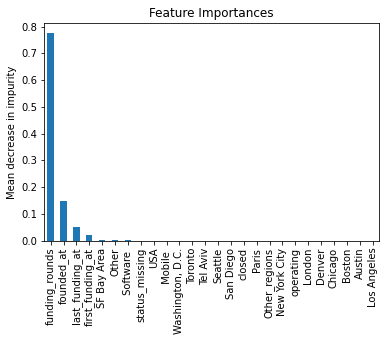

In [33]:
import matplotlib.pyplot as plt

importances = boost_model.feature_importances_

boost_importances = pd.Series(importances, index=X_train.columns.values.tolist()).sort_values(ascending=False)

figure, axis = plt.subplots()
boost_importances.plot.bar(ax=axis)
axis.set_title ("Feature Importances")
axis.set_ylabel ("Mean decrease in impurity")

plt.show()

The graph shows that funding_rounds is the highest impact variable. Additionally, founded_at is of importance as well as
last_funding_at and first_funding_at. This shows that the date variables have a strong predective power. Additionally, for the geographical variables, SF Bay Area is the most important geographical variable.

## Histogram-based Gradient Boosting Regression Tree

In [34]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hist_model = HistGradientBoostingRegressor(random_state=88888)

In [35]:
hist_param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5],
                   'max_leaf_nodes': [2, 6, 8, 10, 20]}

hist_grid = GridSearchCV(estimator=hist_model, param_grid=hist_param_grid, cv=5, n_jobs=-1)

hist_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(random_state=88888),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_leaf_nodes': [2, 6, 8, 10, 20]})

In [36]:
hist_grid.best_score_

0.0990372383499469

In [37]:
hist_model = hist_grid.best_estimator_
hist_model.score(X_test, y_test)

0.15707986317079825

In [38]:
hist_grid.best_params_

{'learning_rate': 0.1, 'max_leaf_nodes': 6}

### Model outcome
The models had the following best outcome:
Linear Regression: 0.1341519690583095.

Random Forest: 0.13428405147992006.

Gradient Boosting Regression Tree: 0.13428405147992006.

Histogram Based Gradient Boosting Regression Tree: 0.15707986317079825.

Out of all the models, the histogram Based Gradient Boosting Regression Tree scores the highest with a best score of 0.15707986317079825

## Plot actual values to predicted values
For the best model, we plot the actual values to the predicted values of the model.

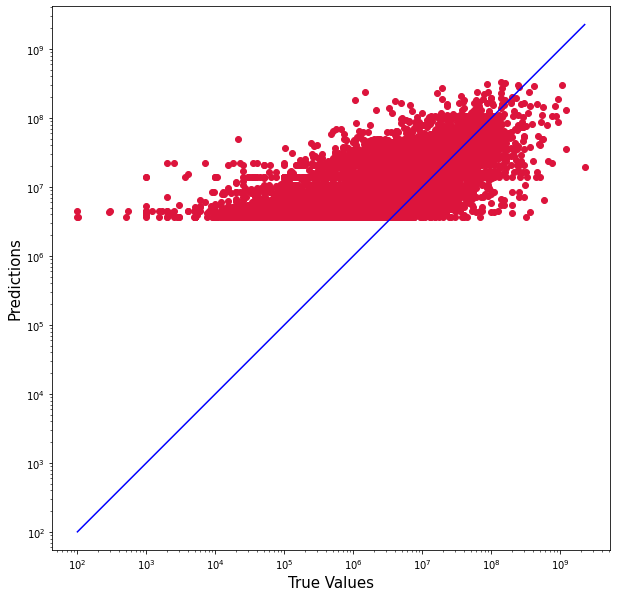

In [39]:
y_predicted = hist_model.predict(X_test)

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

the graph shows that model is relatively weaker at predicting low values of funds recieved, and relatively stronger at predicting higher values of funds recieved.

### -End-